In [384]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr  9 12:38:18 2022

@author: Kevin Tsia
"""


import random
import numpy as np
import argparse
import os
from os import path
from tqdm import tqdm
import time
import copy
import numpy as np

import torch
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from gan_training import utils
from gan_training.train import Trainer, update_average
from gan_training.logger import Logger
from gan_training.checkpoints_test import CheckpointIO
from gan_training.inputs import get_dataset
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval_test import DisentEvaluator, Evaluator
from gan_training.config import (
    load_config, build_models, build_optimizers, build_lr_scheduler
)


from scipy.stats import zscore

In [385]:
#FACTOR
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/LC-Gray/New/Gamma=6.4/'
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/LiveCell/Gamma=100/'
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/CPA3/Gamma=100/'
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/CPA/Gamma=30/2/'
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/CCy/Gamma=6.4/'
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/LC-Gray/New/Gamma=6.4/'
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/EMT/Gamma=6.4/1/'
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Factor/EMT/Gamma=6.4/ConfirmingThresh=0.1/'
#VAE
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/VAE/LiveCell/'

#BETA
#Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/Benchmarking/Beta/CPA/Beta=50/'

Dir='C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/'
Dataset=''
Feat=pd.read_csv(Dir+Dataset+'Dummy.csv')
Cat=pd.read_csv('C:/Users/Rashmi/WorkingLibs/idgan-master_Jan/outputs/TraversalLoop/BGL.csv')

Feat=Feat.loc[(Feat!=0).any(axis=1)]

sns.set(font_scale = 5)
#hierarchical Clustering


In [386]:
Cat

,Cat
0,'Bulk'
1,'Bulk'
2,'Bulk'
3,'Bulk'
4,'Bulk'
5,'Bulk'
6,'Bulk'
7,'Global'
8,'Global'
9,'Global'


In [387]:
normed_matrix = zscore(Feat)
normalized_df= pd.DataFrame(normed_matrix, columns=Feat.columns)
normalized_df=normalized_df.dropna(1)


C:\Users\Kevin Tsia\AppData\Local\Temp\ipykernel_4828\3086402915.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  normalized_df=normalized_df.dropna(1)


In [388]:
sns.set(font_scale = 1 )
from scipy.stats import zscore
#C_10dim=pd.DataFrame(cdim_gan)
#normed_matrix = zscore(Feat)
plt.figure(figsize=(10,10))


df_z_scaled = Feat.copy()
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / (df_z_scaled[column].std())    
normalized_df= pd.DataFrame(df_z_scaled, columns=Feat.columns)
normalized_df=normalized_df.dropna(1)

C:\Users\Kevin Tsia\AppData\Local\Temp\ipykernel_4828\3325497796.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  normalized_df=normalized_df.dropna(1)


<Figure size 720x720 with 0 Axes>

C:\Users\Kevin Tsia\AppData\Local\Temp\ipykernel_4828\3072841073.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  normalized_df=normalized_df.dropna(1)


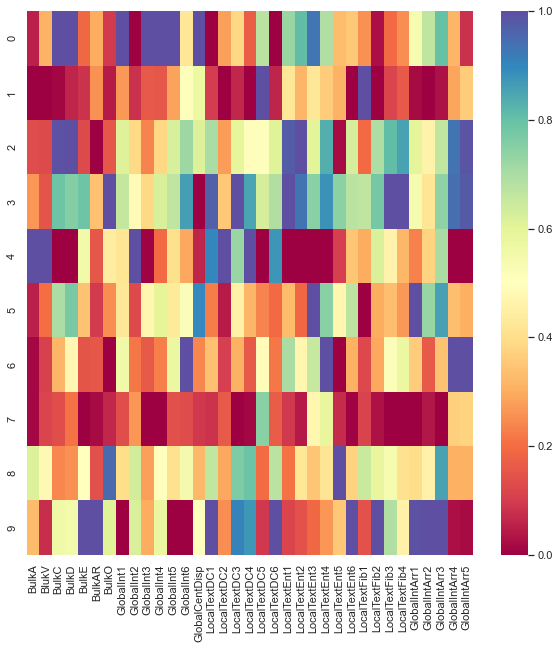

In [389]:
sns.set(font_scale = 1 )
from scipy.stats import zscore
#C_10dim=pd.DataFrame(cdim_gan)
#normed_matrix = zscore(Feat)
plt.figure(figsize=(10,10))

# copy the data
df_min_max_scaled = Feat.copy()
  
# apply Row Scaling technique
for column in Feat.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
sns.heatmap(df_min_max_scaled, cmap='Spectral')
normalized_df= pd.DataFrame(df_min_max_scaled, columns=Feat.columns)
normalized_df=normalized_df.dropna(1)


In [390]:

xs = np.arange(0, 10)
ys = np.arange(0, 3)
colors = ["red", "purple", "green"]


In [391]:
Attr1=['BulkA', 'BlukV', 'BulkC', 'BulkD', 'BulkE', 'BulkO', 'BulkAR'] 
#Attr1=[]
Attr2=['GlobalInt1','GlobalInt2', 'GlobalInt3','GlobalInt4', 'GlobalInt5','GlobalInt6',
       
       'GlobalCentDisp', 'GlobalIntArr1', 'GlobalIntArr2', 'GlobalIntArr3', 'GlobalIntArr4','GlobalIntArr5']
Attr3=[#'LocalTextFit1','LocalTextFit2', 'LocalTextFit3', 'LocalTextFit4',
     'LocalTextDC1', 'LocalTextDC2', 'LocalTextDC3',
      'LocalTextDC4', 'LocalTextDC5', 'LocalTextDC6', 'LocalTextEnt1', 'LocalTextEnt2', 'LocalTextEnt3', 'LocalTextEnt4',
      'LocalTextEnt5', 'LocalTextEnt6', 'LocalTextFib1', 'LocalTextFib2', 'LocalTextFib3', 'LocalTextEnt4']

Attr=[Attr1, Attr2, Attr3]

<Figure size 3600x3600 with 0 Axes>

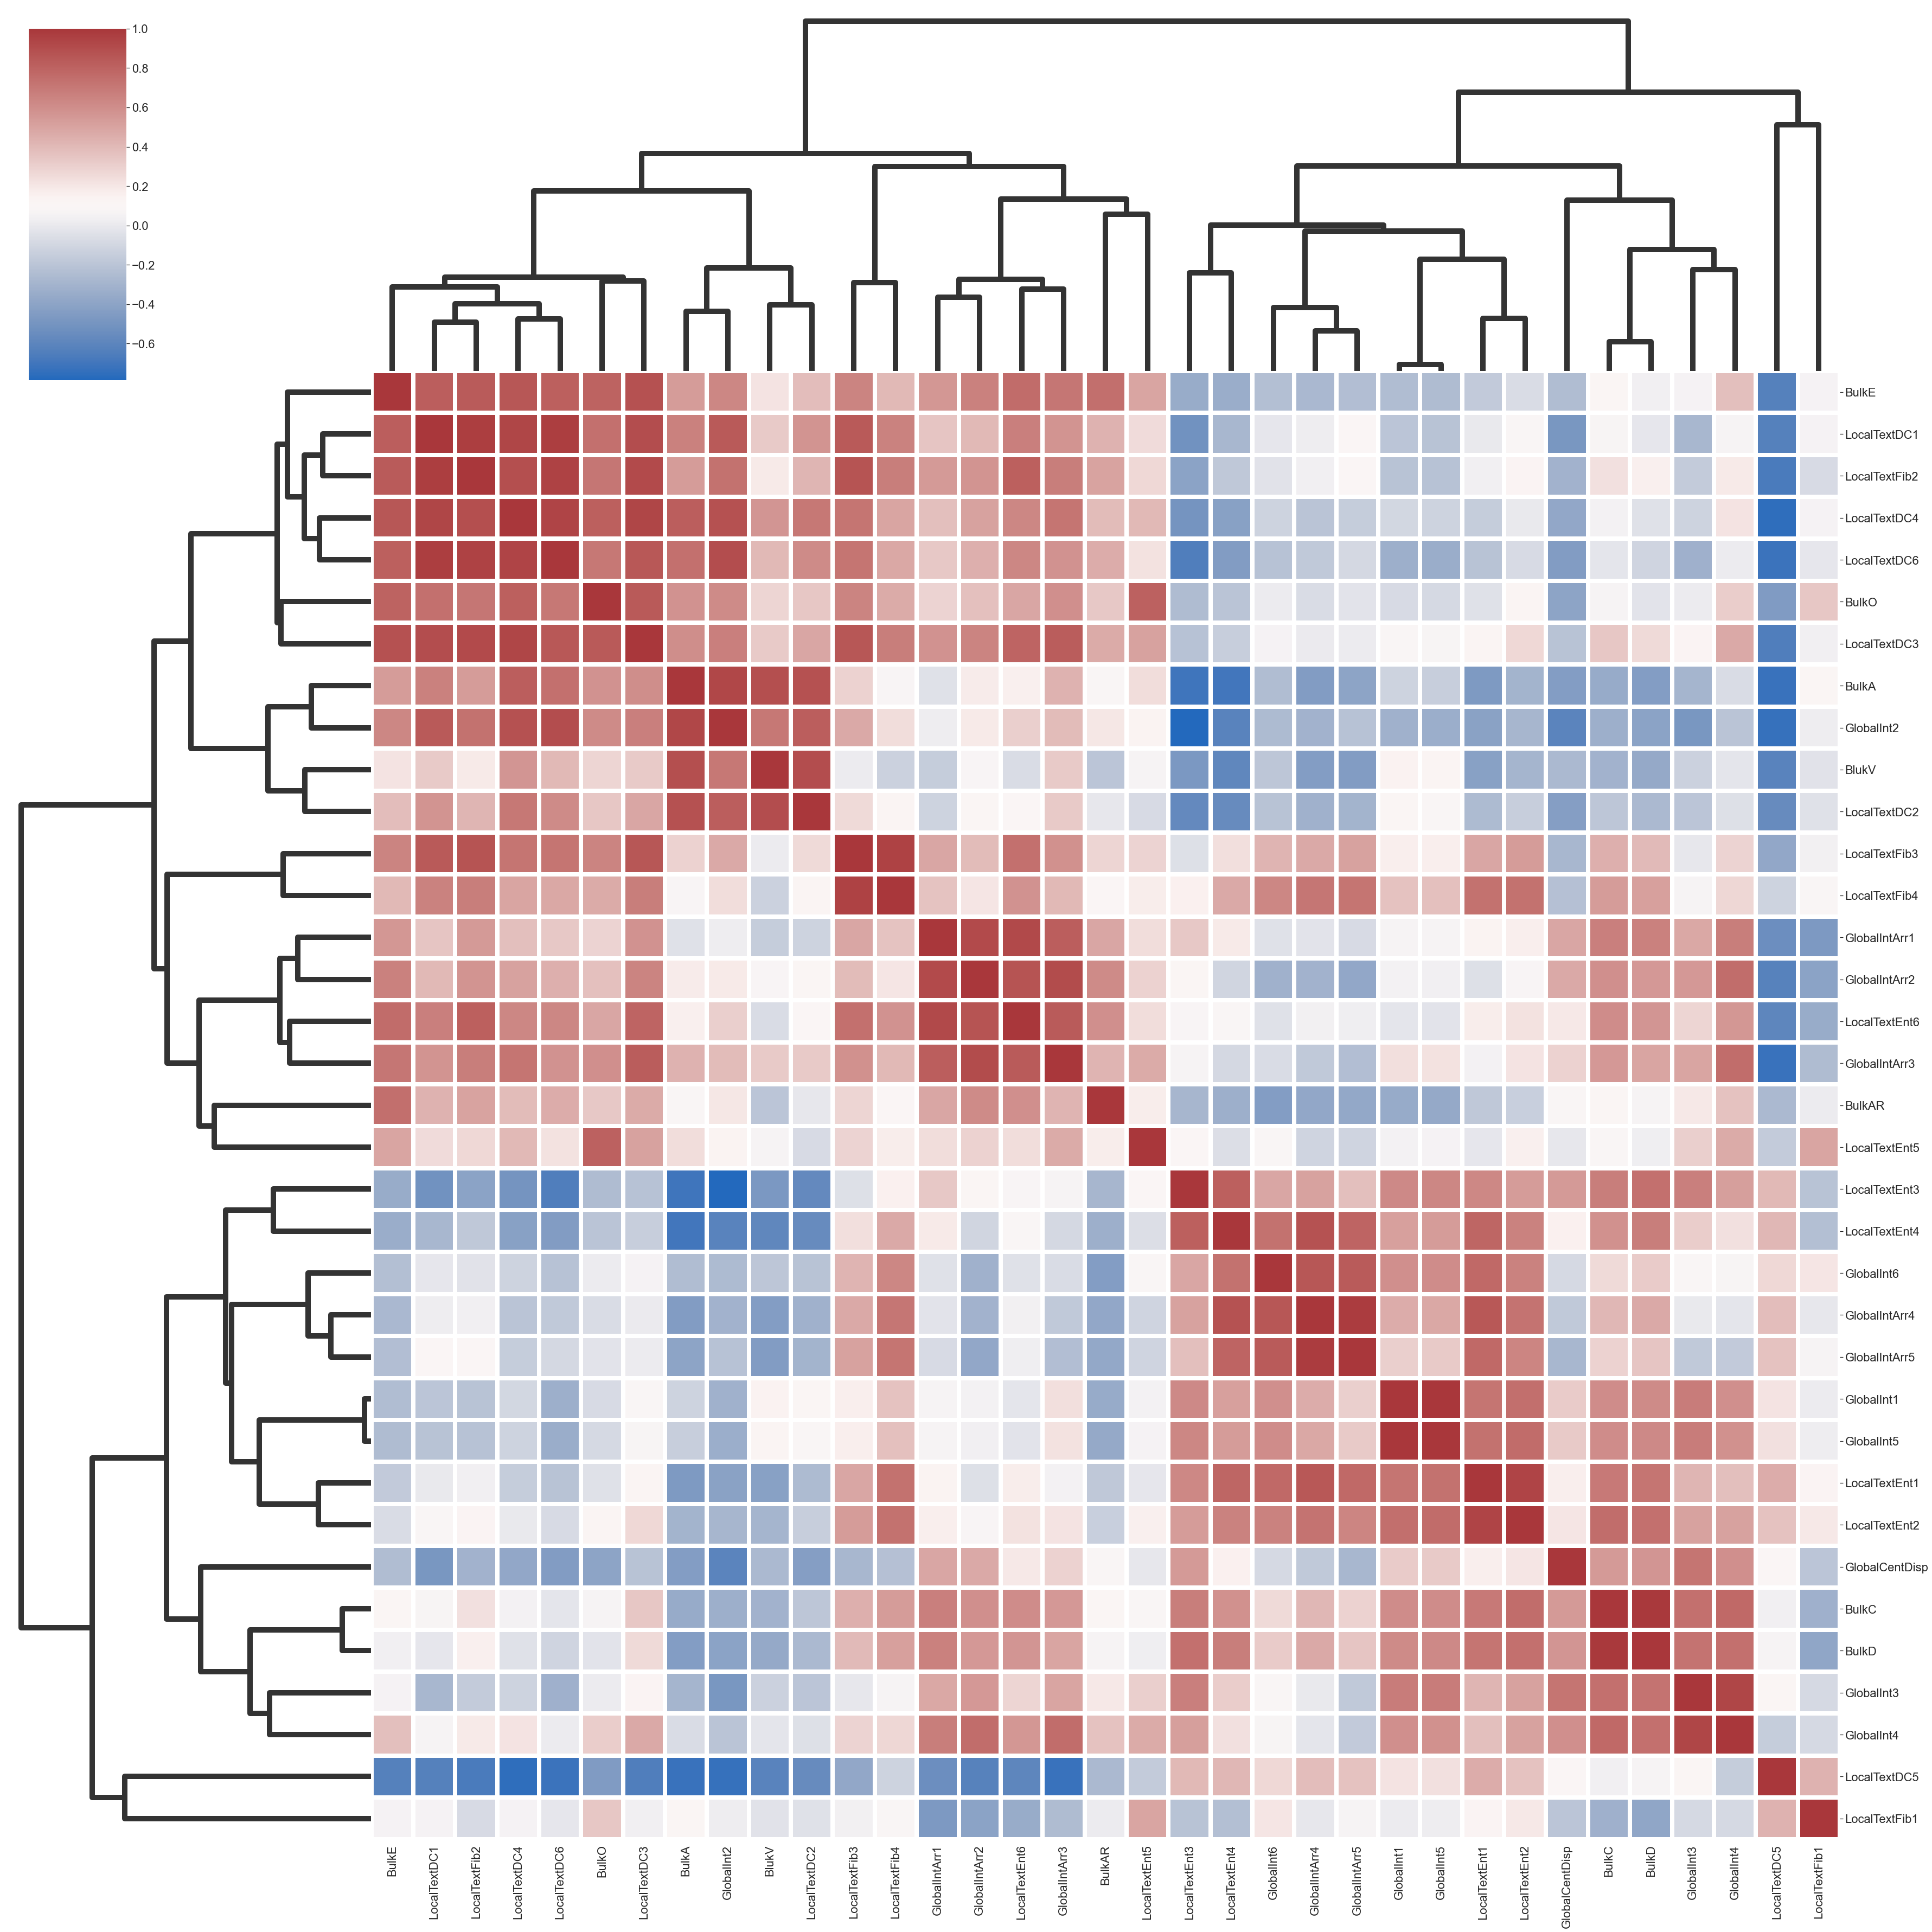

In [392]:

CorrMat=normalized_df.corr(method ='pearson')

#corrmat=normed_matrix.corr(method ='pearson')

sns.set(font_scale = 2 )
plt.figure(figsize=(50,50))
g=sns.clustermap(CorrMat, figsize=(50,50),xticklabels=Feat.columns,linewidths=8,tree_kws=dict(linewidths=10),cmap="vlag")
#g=sns.clustermap(normalized_df, figsize=(120,120),xticklabels=Feat.columns,linewidths=8,tree_kws=dict(linewidths=10))



In [393]:
sns.set(font_scale = 25 )

# First Remove non useful rows
 
g1=sns.clustermap(normalized_df, figsize=(150,150),xticklabels=Feat.columns, fmt='d',linewidths=12,tree_kws=dict(linewidths=12), cmap="YlGnBu")


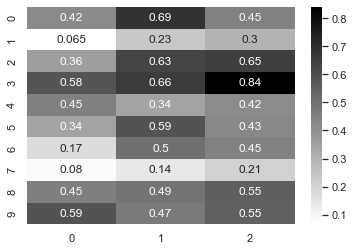

In [394]:
sns.set(font_scale = 1 )

AttrValArray=[]
AttrDim=[]
for dimN in range (0, len(normalized_df)):
    AttrValArray=[]
    MeanAttN=0
    for Attri in Attr:

        for i in range(0, len(Attri)):
            AttrVal=normalized_df.at[dimN, Attri[i]]
            MeanAttN=MeanAttN + AttrVal
        MeanAttN=MeanAttN/len(Attri)
        #if dimN==3 and Attri=='Attr2':

        AttrValArray.append(MeanAttN)
    AttrDim.append(AttrValArray)
AttrDim=np.vstack(AttrDim)    
#a = sns.heatmap(AttrDim, annot=True,row_cluster=True, col_cluster=False ,cmap='binary')
a = sns.heatmap(AttrDim, annot=True,cmap='binary')


<AxesSubplot:>

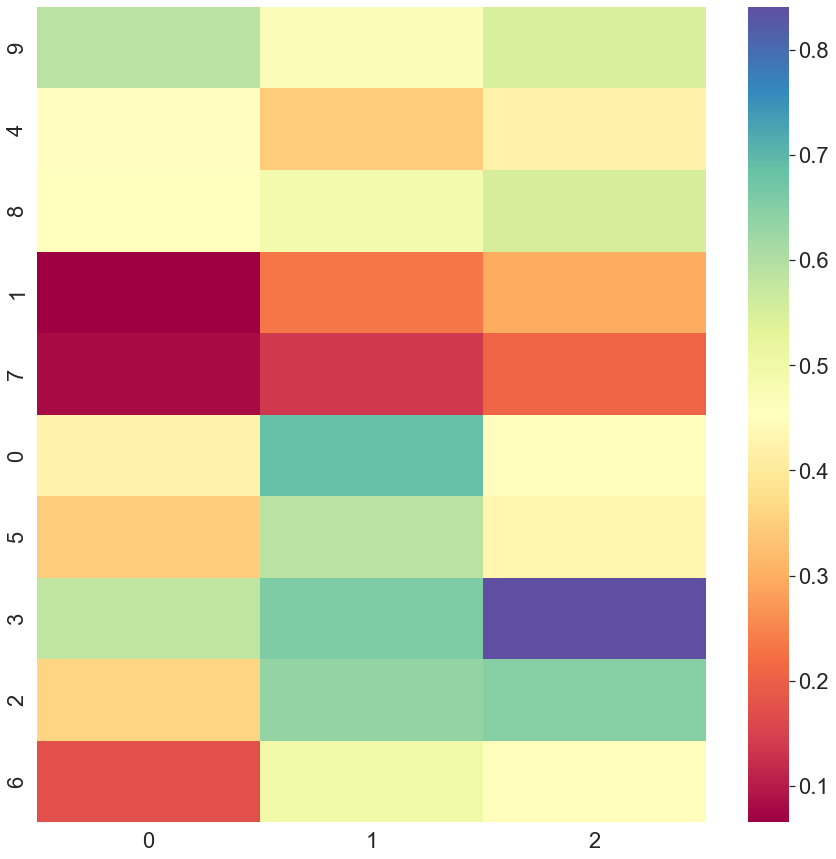

In [399]:
#rearrange=['1', '8', '9', '4', '6', '0', '3', '5', '2', '7'] #CPA
#rearrange=["1", '5', '9', '0', '3', '8', '4', '2', '6', '7']#LiveCell
#rearrange=['3','0','8','6', '5', '4', '9', '7', '1', '2']# Lung Cancer
#rearrange=['3','5','4', '7','6','1','9','2','0','8']#CellCycle
#rearrange=['1','3','9','0','6','5','4','2', '7', '8']#EMT

#New algorithm
#rearrange=['1', '8', '9', '4', '6', '0', '3', '5', '2', '7'] #CPA
#rearrange=["1", '7', '9', '4', '8', '0', '2', '3', '5', '6']#LiveCell
#rearrange=['6','5','4','9', '8', '2', '7', '0', '1', '2']# Lung Cancer
rearrange=['9','4','8', '1','7','0','5','3','2','6']#CellCycle
#rearrange=['5','3','2','4','6','7','8','9', '0', '1']#EMT


#i=0
# copy the data
plt.figure(figsize=(15,15))

sns.set(font_scale = 2)
NewMat=pd.DataFrame(AttrDim)
NewMat = NewMat.iloc[[9, 4, 8, 1, 7, 0, 5, 3, 2, 6], :]    
#NewMat = NewMat.reindex(columns=['3', '0', '8', '6', '5', '4', '9', '7', '1', '2'])
#NewMat=pd.DataFrame.to_numpy(NewMat)
sns.heatmap(NewMat, cmap='Spectral')

0
0
0.42159530285534336
0
1
0.6872059289197873
0
2
0.449265096429755
1
0
0.06547188187597329
1
1
0.23247377917307507
1
2
0.29798923720323883
2
0
0.3619313224182318
2
1
0.6326316247101974
2
2
0.6494350028249153
3
0
0.5828694168930613
3
1
0.6569127261062775
3
2
0.8407348211535567
4
0
0.4506440647514545
4
1
0.344223698265619
4
2
0.41700274704197793
5
0
0.34473537368260626
5
1
0.5869775252146446
5
2
0.4274802053620064
6
0
0.17346988255756465
6
1
0.5010818542453257
6
2
0.448799413996313
7
0
0.079665253732626
7
1
0.13550965773261323
7
2
0.20657286360485588
8
0
0.4546447049332633
8
1
0.489406549023566
8
2
0.5520025647011377
9
0
0.5887579164207344
9
1
0.46936189997322236
9
2
0.5472556015464092


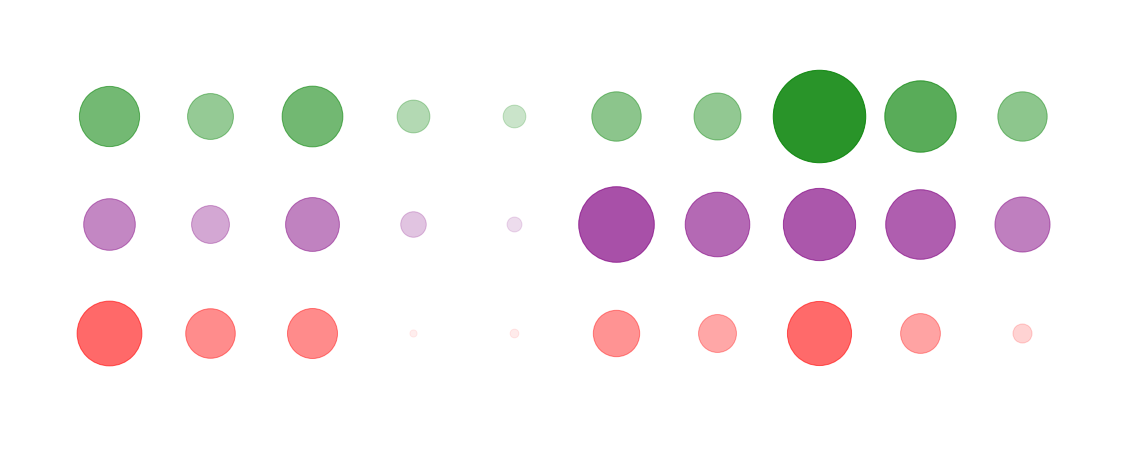

In [400]:
NewMat=np.array(NewMat)
plt.figure(figsize=(20,8))
plt.axis('off')
for x in xs:

        
    for y in ys:
        if y==0:
                square_color='red'
        elif y==1:
            square_color='purple'
        else :
            square_color='green'
        square_size  = NewMat[x,y]
        if (square_size>1):
            square_size=1
        plt.plot(x, y, linestyle="None", marker="o", alpha=square_size,
                 markersize=square_size*110, mfc=square_color, mec=square_color)
        print(x)
        print(y)
        print( AttrDim[x,y])
 

plt.grid(visible=True, axis='x')
plt.xlim(-1, 10)
plt.ylim(-1, 3)
plt.show()

In [332]:
AttrDim[0,2]

0.1032293914816219

In [398]:
maxVar1=0    
maxVar2=0
maxVar3=0
#Compute disentanglement metric from the secondary heatmap
#for i in range(0, len(Attr)):
MaxVar1=max(AttrDim[:,0])
MaxVar2=max(AttrDim[:,1])
MaxVar3=max(AttrDim[:,2])


max_ind1=AttrDim[:,0].tolist().index(MaxVar1)
max_ind2=AttrDim[:,1].tolist().index(MaxVar2)
max_ind3=AttrDim[:,2].tolist().index(MaxVar3)

if max_ind1==max_ind2==max_ind3:
    MaxVar=max(MaxVar1, MaxVar2, MaxVar3)
    Metric=MaxVar/3    
elif max_ind1==max_ind2:
    MaxVar=max(MaxVar1, MaxVar2)
    Metric=(MaxVar+MaxVar2)/3
elif max_ind2==max_ind3:
    MaxVar=max(MaxVar2, MaxVar3)
    Metric=(MaxVar+MaxVar1)/3

elif max_ind1==max_ind3:
    MaxVar=max(MaxVar1, MaxVar3)
    Metric=(MaxVar+MaxVar2)/3

else:
    Metric=(MaxVar1+MaxVar2+MaxVar3)/3

    
print('Metric=')
print(Metric) 

Metric=
0.7055662221646927


In [316]:
df_New=normalized_df

for i, row in normalized_df.iterrows():
    var=(np.var(row) )
    mean=np.mean(row)
    print(var)
    if(var < 0.5):
        if(mean < 0.4):
            df_New=df_New.drop(i)

            
sns.set(font_scale = 20 )

g2=sns.clustermap(df_New, figsize=(140,140),xticklabels=Feat.columns,linewidths=8,tree_kws=dict(linewidths=15), cmap="YlGnBu")


0.12618930684755614
0.06340398712759703
0.08901553768122503
0.0663934445232882
0.12867585810772347
0.07404845306180682
0.08256344991584222
0.030923005790074714
0.04474800260834232
0.13964370320698713


In [19]:
FeatArr= pd.DataFrame.to_numpy(df_New)
cat=Cat.values.tolist()

Dim=["'0'","'1'", "'2'", "'3'", "'4'", "'5'", "'6'", "'7'", "'8'", "'9'"]
cat=["'B'","'L'", "'G'"]

In [20]:
FeatArr.shape[0]

4

In [1034]:
categ=[]
for i in range(0,len(cat)):
    categ.append(i)

In [1035]:
for i in range(0,FeatArr.shape[0]):
    for j in range(0,FeatArr.shape[1]):
        print('[', end="" ) , print((Dim[i]), end="," ), print(str(cat[j][0]),end="," ), print(FeatArr[i,j], end=""), print('],')

['0',',1.0],
['0',',0.8551588387853253],
['0',',0.2266835503975339],
['0',

IndexError: list index out of range

In [ ]:
cat

In [ ]:
for i in range(0,len(Dim)):
    for j in range(0,AttrDim.shape[1]):
        print('[', end="" ) , print((Dim[i]), end="," ), print(str(cat[j]),end="," ), print(AttrDim[i,j], end=""), print('],')

In [116]:
        print('[', end="" ) , print((Dim[i]), end="," ), print(str(cat[j][0]),end="," ), print(FeatArr[i,j], end=""), print('],')

['9',',

IndexError: index 9 is out of bounds for axis 0 with size 6

In [245]:
FeatArr.shape[1]

38

In [204]:
FeatArr[i,]

0.873001826

In [ ]:
cat

In [171]:
for i in cat:
     print(cat[i][0])

TypeError: list indices must be integers or slices, not list